In [1]:
import matplotlib.pyplot as plt
import video_transect, misc
import geopandas
import ffmpeg
import pandas as pd
import datetime
import numpy as np
import tqdm
import pathlib

from video_transect import image_from_video
from video_transect import sec_to_timestring

In [2]:
# Paths
video_dir = '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro'
# video_dir = '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/TestImageExtraction'
# video_dir = '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_02/20220820_160305_Sola02/GoPro'
# video_dir = '/media/mha114/Massimal/Bodo_Juvika/Video-WalkGroundTransect'

csv_file = '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/CSV and mat files/20220820_134500_GnssTimePosHeadCourSpeed.csv'
image_dir = '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/Extracted images'
gpk_file = '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/Images Geopackage/Sola_1b.gpkg'

In [3]:
video_files = misc.file_pattern_search(video_dir, '*.[Mm][Pp]4')

In [4]:
video_files

['/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX010060.MP4',
 '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4',
 '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX030060.MP4',
 '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX040060.MP4',
 '/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX050060.MP4']

In [5]:
probe_data = ffmpeg.probe(video_files[0])

In [6]:
probe_data['streams'][0]['tags']

{'creation_time': '2022-08-20T15:33:49.000000Z',
 'language': 'eng',
 'handler_name': '\x0bGoPro H.265',
 'encoder': 'GoPro H.265 encoder',
 'timecode': '15:32:53:03'}

In [7]:
import pytz
print(pytz.common_timezones)


['Africa/Abidjan', 'Africa/Accra', 'Africa/Addis_Ababa', 'Africa/Algiers', 'Africa/Asmara', 'Africa/Bamako', 'Africa/Bangui', 'Africa/Banjul', 'Africa/Bissau', 'Africa/Blantyre', 'Africa/Brazzaville', 'Africa/Bujumbura', 'Africa/Cairo', 'Africa/Casablanca', 'Africa/Ceuta', 'Africa/Conakry', 'Africa/Dakar', 'Africa/Dar_es_Salaam', 'Africa/Djibouti', 'Africa/Douala', 'Africa/El_Aaiun', 'Africa/Freetown', 'Africa/Gaborone', 'Africa/Harare', 'Africa/Johannesburg', 'Africa/Juba', 'Africa/Kampala', 'Africa/Khartoum', 'Africa/Kigali', 'Africa/Kinshasa', 'Africa/Lagos', 'Africa/Libreville', 'Africa/Lome', 'Africa/Luanda', 'Africa/Lubumbashi', 'Africa/Lusaka', 'Africa/Malabo', 'Africa/Maputo', 'Africa/Maseru', 'Africa/Mbabane', 'Africa/Mogadishu', 'Africa/Monrovia', 'Africa/Nairobi', 'Africa/Ndjamena', 'Africa/Niamey', 'Africa/Nouakchott', 'Africa/Ouagadougou', 'Africa/Porto-Novo', 'Africa/Sao_Tome', 'Africa/Tripoli', 'Africa/Tunis', 'Africa/Windhoek', 'America/Adak', 'America/Anchorage', 'Amer

In [8]:
def otter_csv_to_geodataframe(csv_file):
    """ Read position and timestamp from Otter CSV file

    # Usage:
    otter_csv_to_geodataframe(csv_file)

    # Required arguments:
    csv_file:   CSV file with track data, generated by Otter
                and post-processed in Matlab.
                Columns "LatDecDeg", "LongDecDeg" and "GnssUTC" are used

    # Returns
    gdf:        GeoDataFrame with information extracted from CSV file
                Columns are renamed "Lat", "Lng" and "Time"

    """

    # Read data
    data = pd.read_csv(csv_file,usecols=['LatDecDeg','LongDecDeg','GnssUTC'])
    data.columns = ['Time','Lat','Lng']                   # Rename columns
    data.Time = pd.to_datetime(data.Time,utc=True)        # Convert time string to datetime format

    # Create GeoDataFrame
    gdf = geopandas.GeoDataFrame(
        data,
        crs = 'EPSG:4326',
        geometry=geopandas.points_from_xy(data.Lng, data.Lat))

    # Return
    return gdf

In [9]:
def filter_gdf_on_distance(gdf,sample_distance,epsg=32633, inplace=False, outlier_distance = 1000):
    """ Filter a geodataframe by only including new samples if position has changed
    
    # Usage:
    gdf_filtered = filter_gdf_on_distance(gdf,...)

    # Input arguments:
    gdf:                  GeoPandas GeoDataFrame object
    sample_distance       Minimum change in position in order for next sample to be included
                          Units are defined by CRS (set as EPSG code, see kwarg epsg)
    
    # Keyword arguments:
    epsg:                EPSG code (integer) for CRS to measure distance in
                         Default: 32633 (UTM 33N)
                         If epsg=None, the existing CRS for the geodataframe is used
    outlier_distance     Samples with changes in distance above this limit are not included
                         Units are defined by CRS
    
    """
    
    # Convert CRS (often necessary to get valid distance units, e.g. meters)
    if epsg is not None:
        geom = gdf.geometry.to_crs(epsg=epsg)
    else:
        geom = gdf.geometry
        
    # Iterate over all positions, and only include a new point if position 
    # has changed more than sample_distance
    mask = [0]           # Always include first point
    last_pos = geom[0]   # Position at first point
    for index, position in enumerate(geom):
        dist = position.distance(last_pos)
        if (dist > sample_distance) and (dist < outlier_distance):
            mask.append(index)
            last_pos = position
    
    # Return a filtered copy of the original geodataframe
    return gdf.iloc[mask]
        

In [10]:
gdf = otter_csv_to_geodataframe(csv_file)

In [11]:
# sample_distance=0.7
sample_distance=10.0
gdf_simp = filter_gdf_on_distance(gdf,sample_distance)

In [12]:
gdf_simp

,Time,Lat,Lng,geometry
0,2022-08-20 13:45:00.957000+00:00,65.678659,11.719861,POINT (11.71986 65.67866)
925,2022-08-20 13:46:33.397000+00:00,65.678630,11.720067,POINT (11.72007 65.67863)
1179,2022-08-20 13:46:58.788000+00:00,65.678544,11.720003,POINT (11.72000 65.67854)
1367,2022-08-20 13:47:17.587000+00:00,65.678536,11.720221,POINT (11.72022 65.67854)
1548,2022-08-20 13:47:35.696000+00:00,65.678554,11.720434,POINT (11.72043 65.67855)
...,...,...,...,...
38211,2022-08-20 14:48:41.987000+00:00,65.678286,11.719881,POINT (11.71988 65.67829)
38411,2022-08-20 14:49:01.986000+00:00,65.678357,11.719747,POINT (11.71975 65.67836)
38618,2022-08-20 14:49:22.688000+00:00,65.678437,11.719849,POINT (11.71985 65.67844)
38786,2022-08-20 14:49:39.487000+00:00,65.678506,11.719986,POINT (11.71999 65.67851)


In [13]:
# Check timezone for Otter data (should be UTC)
gdf_simp.iloc[0].Time

Timestamp('2022-08-20 13:45:00.957000+0000', tz='UTC')

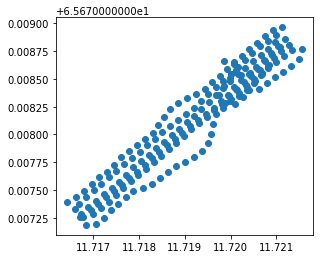

In [14]:
# Plot points in geodataframe (sanity check)
gdf_simp.plot()
plt.show()

In [15]:
def get_video_data(video_dir, tz='Europe/Oslo'):
    """ Get info about videos in folder, organized as dataframe

    # Usage:
    video_data = get_video_data(video_dir)

    # Arguments:
    video_dir:      Path to folder with video file(s).
                    Files are assumed to be from a single continuous "take",
                    split into files with names ordered alphabetiacally
                    according to recording order.
    
    # Keyword arguments:
    tz              Timezone for video. Default: 'Europe/Oslo'
                    To see available options:
                    > import pytz
                    > print(pytz.common_timezones)

    # Returns:
    video_data:     Pandas dataframe with columns
                    'FileName', 'DurationSec','StartTimeSec','StopTimeSec'
                    Start and stop times are relative to start of first file.

    """

    video_data = pd.DataFrame({ 'FileName':'',
                                'CreationTime':pd.Timestamp(0,tz=tz),
                                'DurationSec':float(),
                                'StartTimeSec':float(),
                                'StopTimeSec':float()},
                                 index=[])

    # Get list of video files, insert into dataframe
    # Use brackets to find both .mp4 and .MP4 files
    video_data.FileName = misc.file_pattern_search(video_dir, '*.[Mm][Pp]4')

    # Get creation time, duration and frame rate for each video file
    # Keep times timezone naive
    for ii,file in enumerate(video_data['FileName']):
        probe_data = ffmpeg.probe(file)
        video_data.loc[ii,'CreationTime'] = pd.to_datetime( \
            probe_data['streams'][0]['tags']['creation_time']). \
            tz_localize(None).tz_localize(tz)  # "Reset" to no timezone, then set timezone
        video_data.loc[ii,'DurationSec'] = pd.to_numeric(probe_data['streams'][0]['duration'])
    
    # Calculate start and stop times for each video in seconds, relative to start of video
    # Note that columns.get_loc() needs to be used below in order to access dataframs
    # by integer indices only.
    video_data.loc[0,'StartTimeSec'] = 0.0
    video_data.iloc[1:,video_data.columns.get_loc('StartTimeSec')] = np.cumsum(
        video_data.iloc[:-1,video_data.columns.get_loc('DurationSec')])
    video_data.StopTimeSec = video_data.StartTimeSec + video_data.DurationSec

    return video_data

In [16]:
video_data = get_video_data(video_dir)

In [17]:
video_data

,FileName,CreationTime,DurationSec,StartTimeSec,StopTimeSec
0,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,2022-08-20 15:33:49+02:00,704.704000,0.000,704.704000
1,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,2022-08-20 15:33:49+02:00,704.704000,704.704,1409.408000
2,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,2022-08-20 15:33:49+02:00,704.704000,1409.408,2114.112000
3,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,2022-08-20 15:33:49+02:00,704.704000,2114.112,2818.816000
4,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,2022-08-20 15:33:49+02:00,329.195533,2818.816,3148.011533


In [18]:
video_data.iloc[0].CreationTime

Timestamp('2022-08-20 15:33:49+0200', tz='Europe/Oslo')

In [19]:
def prepare_gdf_with_video_data(gdf,video_data, video_time_offset=pd.Timedelta(0)):
    """ Insert video information into geodataframe, prepare for extracting images

    # Usage:
    gdf = prepare_gdf_with_video_data(gdf,video_data)

    # Arguments:
    gdf:        geodataframe with positions and timestamps
                (see track_csv_to_geodataframe())
    video_data: dataframe with video data
                (see get_video_data())
    
    # Keyword arguments:
    video_time_offset:    pandas.Timedelta object with time difference between
                          video datetime ("CreationTime") and GNSS track datetime.
                          Example: GoPro camera at Norwegian local time and 
                          daylight saving time is 2 hours "in front of"
                          GNNS using UTC time, resulting in
                          video_time_offset = pandas.Timedelta(hours=2)

    # Returns
    gdf:        geodataframe with video information inserted
    """

    # Create copy of original geodataframe
    gdf = gdf.copy()
    
    # Insert additional columns
    gdf.insert(gdf.shape[1]-1,'VideoFile','')
    gdf.insert(gdf.shape[1]-1,'TimeRelToVideoStart',pd.Timedelta(0))
    gdf.insert(gdf.shape[1]-1,'TimeRelToFileStartSec',float())
    
    # Calculate time for logged positions relative to video
    gdf.TimeRelToVideoStart = gdf.Time - (video_data.iloc[0].CreationTime - video_time_offset)
    
    # Exclude positions outside video time window
    ind_within_video_duration = (gdf.TimeRelToVideoStart >= pd.Timedelta(0)) & (
                                 gdf.TimeRelToVideoStart <= pd.Timedelta(seconds=video_data.iloc[-1].StopTimeSec))
    gdf = gdf[ind_within_video_duration]

    # For each position, find corresponding video file and calculate time relative to start of video
    for ii in range(video_data.shape[0]):
        # Create index for rows within current video time window
        ind = (gdf.TimeRelToVideoStart >= pd.Timedelta(seconds=video_data.iloc[ii].StartTimeSec)) & (
               gdf.TimeRelToVideoStart < pd.Timedelta(seconds=video_data.iloc[ii].StopTimeSec))
        # Set video file and times for current video 
        gdf.loc[ind, 'VideoFile'] = video_data.iloc[ii].FileName
        time_rel_to_video_start = gdf.loc[ind, 'TimeRelToVideoStart'] - pd.Timedelta(seconds=video_data.iloc[ii].StartTimeSec)
        gdf.loc[ind, 'TimeRelToFileStartSec'] = time_rel_to_video_start.dt.total_seconds() #gdf.loc[ind, 'TimeRelToVideoStart'] - pd.Timedelta(seconds=video_data.iloc[ii].StartTimeSec)
        
    return gdf

In [20]:
video_time_offset = pd.Timedelta(hours=0)
gdf_with_video = prepare_gdf_with_video_data(gdf_simp,video_data,video_time_offset=video_time_offset)
gdf_with_video

,Time,Lat,Lng,VideoFile,TimeRelToVideoStart,TimeRelToFileStartSec,geometry
0,2022-08-20 13:45:00.957000+00:00,65.678659,11.719861,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:11:11.957000,671.957,POINT (11.71986 65.67866)
925,2022-08-20 13:46:33.397000+00:00,65.678630,11.720067,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:12:44.397000,59.693,POINT (11.72007 65.67863)
1179,2022-08-20 13:46:58.788000+00:00,65.678544,11.720003,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:13:09.788000,85.084,POINT (11.72000 65.67854)
1367,2022-08-20 13:47:17.587000+00:00,65.678536,11.720221,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:13:28.587000,103.883,POINT (11.72022 65.67854)
1548,2022-08-20 13:47:35.696000+00:00,65.678554,11.720434,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:13:46.696000,121.992,POINT (11.72043 65.67855)
...,...,...,...,...,...,...,...
24146,2022-08-20 14:25:15.490000+00:00,65.678826,11.720580,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:51:26.490000,267.674,POINT (11.72058 65.67883)
24273,2022-08-20 14:25:28.178000+00:00,65.678768,11.720414,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:51:39.178000,280.362,POINT (11.72041 65.67877)
24411,2022-08-20 14:25:41.985000+00:00,65.678710,11.720248,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:51:52.985000,294.169,POINT (11.72025 65.67871)
24562,2022-08-20 14:25:57.089000+00:00,65.678651,11.720085,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:52:08.089000,309.273,POINT (11.72008 65.67865)


In [21]:
for file in gdf_with_video.iloc[0:10].VideoFile:
    print(file)

/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX010060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4
/media/mha114/Massimal/Vega_Sola/Transects/Otter/Sola_01/20220820_134500_Sola01b/GoPro/GX020060.MP4


In [48]:
def extract_images_from_video(gdf,image_dir):
    """ Extract images from video transect

    # Usage:
    gdf = extract_images_from_video(gdf,image_dir)

    # Required arguments:
    gdf:        geodataframe from prepare_gdf_with_video_data()
    image_dir:  path to folder where images will be stored

    # Returns:
    gdf:        geodataframe with image file names inserted
                (relative path with parent directory included)
    """

    # Create copy to avoid changing original geodataframe
    gdf = gdf.copy()
    
    # Convert datetimes and timedeltas to strings (needed to save as GPKG)
    gdf.Time = gdf.Time.dt.strftime('%Y-%m-%d %H:%M:%S.%f%z')
    gdf.TimeRelToVideoStart = gdf.TimeRelToVideoStart.astype(str)
    
    # Insert additional column for image path
    gdf.insert(gdf.shape[1]-1,'ImageFile','')

    # Loop over every row, create image and save image file name
    for ii in tqdm.tqdm(range(len(gdf))):    # Use tqdm to display progress bar
        # Create file name and log it to the geodataframe
        image_file_name = pathlib.Path(gdf.iloc[ii].VideoFile).stem + '_' + \
                           sec_to_timestring(gdf.iloc[ii].TimeRelToFileStartSec) + '.jpg'
        gdf.iloc[ii, gdf.columns.get_loc('ImageFile')] = str(image_file_name)  # Must use get_loc for "mixed" indexing with ints and names
        
        # Create absolute path
        abs_path = pathlib.Path(image_dir,image_file_name)

        # Extract image from video and save
        image_from_video(gdf.iloc[ii].VideoFile,
                            str(abs_path),
                            gdf.iloc[ii].TimeRelToFileStartSec)

    return gdf

In [49]:
# Try extracting images from video
gdf_with_images = extract_images_from_video(gdf_with_video,image_dir)
gdf_with_images

100%|█████████████████████████████████████████| 136/136 [01:24<00:00,  1.61it/s]


,Time,Lat,Lng,VideoFile,TimeRelToVideoStart,TimeRelToFileStartSec,ImageFile,geometry
0,2022-08-20 13:45:00.957000+0000,65.678659,11.719861,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:11:11.957000,671.957,GX010060_11m11s957ms.jpg,POINT (11.71986 65.67866)
925,2022-08-20 13:46:33.397000+0000,65.678630,11.720067,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:12:44.397000,59.693,GX020060_00m59s693ms.jpg,POINT (11.72007 65.67863)
1179,2022-08-20 13:46:58.788000+0000,65.678544,11.720003,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:13:09.788000,85.084,GX020060_01m25s084ms.jpg,POINT (11.72000 65.67854)
1367,2022-08-20 13:47:17.587000+0000,65.678536,11.720221,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:13:28.587000,103.883,GX020060_01m43s883ms.jpg,POINT (11.72022 65.67854)
1548,2022-08-20 13:47:35.696000+0000,65.678554,11.720434,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:13:46.696000,121.992,GX020060_02m01s992ms.jpg,POINT (11.72043 65.67855)
...,...,...,...,...,...,...,...,...
24146,2022-08-20 14:25:15.490000+0000,65.678826,11.720580,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:51:26.490000,267.674,GX050060_04m27s674ms.jpg,POINT (11.72058 65.67883)
24273,2022-08-20 14:25:28.178000+0000,65.678768,11.720414,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:51:39.178000,280.362,GX050060_04m40s362ms.jpg,POINT (11.72041 65.67877)
24411,2022-08-20 14:25:41.985000+0000,65.678710,11.720248,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:51:52.985000,294.169,GX050060_04m54s169ms.jpg,POINT (11.72025 65.67871)
24562,2022-08-20 14:25:57.089000+0000,65.678651,11.720085,/media/mha114/Massimal/Vega_Sola/Transects/Ott...,0 days 00:52:08.089000,309.273,GX050060_05m09s273ms.jpg,POINT (11.72008 65.67865)


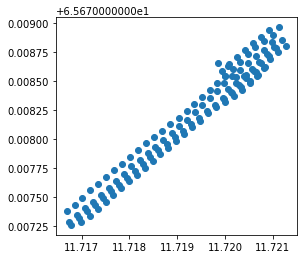

In [50]:
gdf_with_images.plot()
plt.show()

In [54]:
# Save GDF with image file names
gdf_with_images.to_file(gpk_file, driver="GPKG")

In [51]:
tmp = gdf_with_images.iloc[0].Time

In [29]:
tmp.strftime('%Y-%m-%d %H:%M:%S.%f%z')

'2022-08-20 13:45:00.957000+0000'

In [52]:
tmp

'2022-08-20 13:45:00.957000+0000'

In [35]:
#gdf_with_images.Time = gdf_with_images.Time.dt.strftime('%Y-%m-%d %H:%M:%S.%f%z')
gdf_with_images.TimeRelToVideoStart	= gdf_with_images.TimeRelToVideoStart.dt.strftime('%H:%M:%S.%f')

AttributeError: 'TimedeltaProperties' object has no attribute 'strftime'

In [33]:
gdf_with_images.iloc[0].Time

'2022-08-20 13:45:00.957000+0000'

In [53]:
gdf_with_images.iloc[0].TimeRelToVideoStart

'0 days 00:11:11.957000'

In [37]:
tmp2 = gdf_with_images.iloc[0].TimeRelToVideoStart

In [41]:
tmp2.astype(str)

AttributeError: 'Timedelta' object has no attribute 'astype'

In [40]:
tmp.to_pydatetime()

datetime.datetime(2022, 8, 20, 13, 45, 0, 957000, tzinfo=<UTC>)

In [47]:
gdf_with_images.TimeRelToVideoStart.astype(str)

0        0 days 00:11:11.957000
925      0 days 00:12:44.397000
1179     0 days 00:13:09.788000
1367     0 days 00:13:28.587000
1548     0 days 00:13:46.696000
                  ...          
24146    0 days 00:51:26.490000
24273    0 days 00:51:39.178000
24411    0 days 00:51:52.985000
24562    0 days 00:52:08.089000
24717    0 days 00:52:23.576000
Name: TimeRelToVideoStart, Length: 136, dtype: object